<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the MC decays of Kr38m and bb0nu events simulated in a "realistic" fiber barrel. A mapping of the signal depending on the spatial position is perfomed in the XY plane and Z-axis and then used to determine the energy resolution at Krypton's decay energy. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>



In [5]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

In [6]:
yield_ = 1050 # ph/e⁻
# yield_ = 2000 # ph/e⁻


<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [7]:
# path = '/home/investigator/mariandbt/nexus'
# filename = os.path.join(path, "Next100_full.next.h5")

path = '/home/investigator/mariandbt/python/data'
# # path = path + '/20230921_NEXT100_full_fiber_barrel'
path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "Next100_full_Kr_noEL_10Kev.next.h5")
# filename = os.path.join(path, "Next100_full_mapp_s2_mitadActive_10Kev.next.h5")
# filename = os.path.join(path, "Next100_full_mapp_s2_inicioEL_10Kev.next.h5")
filename = os.path.join(path, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")

# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_1event.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev_sensName.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_20ev.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [8]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/Next100_full_mapp_s2_inicioEL_100Kev.next.h5 (File) ''
Last modif.: '2023-11-14T11:00:27+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(49,)) ''
/MC/hits (Table(0,)) ''
/MC/particles (Table(100000,)) ''
/MC/sns_positions (Table(3524,)) ''
/MC/sns_response (Table(1455365,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [9]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
particles = pd.read_hdf(filename, "/MC/particles")
sensors = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")


In [10]:
dst_particle = particles.copy()
sens = sensors.copy()
dst = data.copy()


In [11]:
dst_particle
len(dst_particle.loc[(dst_particle.creator_proc == "Electroluminescence")])
# dst_particle.loc[(dst_particle.creator_proc == "Electroluminescence")]

0

In [12]:
sens

,sensor_id,sensor_name,x,y,z
0,222,F_SENSOR,2.842171e-14,482.558960,8.225000
1,203,F_SENSOR,4.811318e+02,50.312019,8.225000
2,273,F_SENSOR,1.330953e+02,-465.085785,8.225000
3,204,F_SENSOR,4.870359e+02,16.828556,8.225000
4,240,F_SENSOR,-4.870359e+02,16.828556,8.225000
5,200,F_SENSOR,4.634197e+02,150.762405,8.225000
6,266,F_SENSOR,3.400000e+01,-482.558960,8.225000
7,201,F_SENSOR,4.693238e+02,117.278946,8.225000
8,289,F_SENSOR,4.634197e+02,-150.762405,8.225000
9,264,F_SENSOR,-2.289440e+02,-430.199707,8.225000


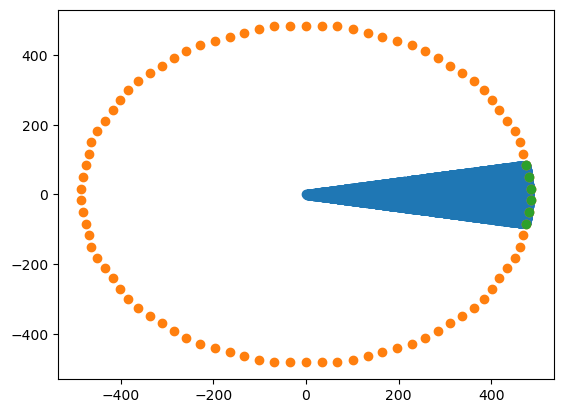

In [13]:
plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
plt.plot(fib_sens.x, fib_sens.y, 'o')

sector_sens = fib_sens.loc[(fib_sens.y > dst_particle.initial_y.min() - 10) &
                           (fib_sens.y < dst_particle.initial_y.max() + 10) &
                           (fib_sens.x > 0.)
                          ]
plt.plot(sector_sens.x, sector_sens.y, 'o')

plt.show()

In [14]:
sector_sens

,sensor_id,sensor_name,x,y,z
1,203,F_SENSOR,481.131836,50.312019,8.225
3,204,F_SENSOR,487.035889,16.828556,8.225
31,287,F_SENSOR,475.227814,-83.795486,8.225
32,285,F_SENSOR,487.035889,-16.828556,8.225
33,286,F_SENSOR,481.131836,-50.312019,8.225
34,202,F_SENSOR,475.227814,83.795486,8.225


In [15]:
dst_particle.initial_y.min()

-83.23578643798828

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [16]:
# dst_particle.initial_z.unique()

In [17]:
# plt.plot(dst_particle.final_z, dst_particle.final_x, 'o')
# plt.show()

In [18]:
# plt.plot(dst_particle.final_z, dst_particle.final_y, 'o')
# plt.show()

In [19]:
# plt.plot(dst_particle.final_x, dst_particle.final_y, 'o')
# plt.show()

In [20]:
# plt.plot(dst_particle.initial_z, dst_particle.initial_y, 'o')
# plt.show()

In [21]:
# plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')
# plt.show()

In [22]:
# dst_particle.initial_y.min()

In [23]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [24]:
n_events = dst_particle.event_id.max() + 1 # save number of events simulated

# *** OJO AQUII!!

In [25]:
# we select the response of the sensors at the end of the fibers

fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors


In [26]:
selected_sens = np.sort(sens_fibers.sensor_id)[3] # ID and position of the sensor we're looking at

In [27]:
sens_response = dst.loc[dst.sensor_id == selected_sens] # response of the selected sensor

In [28]:
# keep track of the events with no counts
no_counts_events = set(range(n_events)) - set(sens_response.event_id.unique()) 
# print(f'Events {no_counts_events} did not have any counts')

# Create a DataFrame with all event IDs
all_event_ids = pd.DataFrame({'event_id': range(n_events)})

# Merge the two DataFrames to align charge values
sens_response = all_event_ids.merge(sens_response, on='event_id', how='left').fillna(0)


In [29]:
event_charge = sens_response.groupby("event_id").charge.sum() # total charge detected on each event

# *** 

- <p style="font-size: 17px; color: black;"> <b> Save the coordinates of each event: </b> Since the initial coordinates are the same for all primary particles in the event we need to only save the 1st. </p>

In [30]:
ev_x0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_x.first()
ev_y0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_y.first()
ev_z0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_z.first()

In [31]:
len(ev_x0), len(event_charge)

(100000, 100000)

- <p style="font-size: 17px; color: black;"> <b> Map the charge PER SENSOR vs positon hists: </b> Map in XY with a 2D histogram and in Z-axis with a 1D histogram. </p>

In [32]:
# n_bins = int(np.sqrt(n_events))
n_bins = 20

bin_width = 10 # [mm]
x_nbins = int((ev_x0.max() - ev_x0.min())/bin_width)
y_nbins = int((ev_y0.max() - ev_y0.min())/bin_width)
# x_nbins = y_nbins = n_bins
bins = (x_nbins, y_nbins)

# bins = (20, 50)
font_size = 11
offset = 0.

In [33]:
# XY-plane

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                      bins=bins, 
                                      weights = event_charge,
                                      density=False);

hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                             bins=bins, 
                                             density=False);

# Calculate the mean values in each bin (normalized histogram)
hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


/tmp/ipykernel_12235/1926091879.py:14: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


In [34]:

# Initialize lists to store statistics for each bin
mean_per_bin = np.zeros((x_nbins, y_nbins))
std_per_bin = np.zeros((x_nbins, y_nbins))
entries_per_bin = np.zeros((x_nbins, y_nbins))
mean_per_bin_err = np.zeros((x_nbins, y_nbins))

# Iterate over each bin
for i in range(x_nbins):
    for j in range(y_nbins):
        # Indices of data points in the current bin
        mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))
        
        # Extract values and weights in the current bin
        values_in_bin = event_charge[mask]
        
        # Calculate weighted mean and standard deviation
        mean_value = np.mean(values_in_bin)
        std_value = np.std(values_in_bin)
        entries_value = len(values_in_bin)

        # Append to lists
        mean_per_bin[i][j] = mean_value
        std_per_bin[i][j] = std_value
        entries_per_bin[i][j] = entries_value
        mean_per_bin_err[i][j] = np.where(entries_value*mean_value> 0., 
                                          std_value*100/(np.sqrt(entries_value)*mean_value), 
                                          0.)
        
mean_per_bin = np.nan_to_num(mean_per_bin)
std_per_bin = np.nan_to_num(std_per_bin)
entries_per_bin = np.nan_to_num(entries_per_bin)
mean_per_bin_err = np.nan_to_num(mean_per_bin_err)

/tmp/ipykernel_12235/1005221130.py:27: RuntimeWarning: invalid value encountered in double_scalars
  std_value*100/(np.sqrt(entries_value)*mean_value),


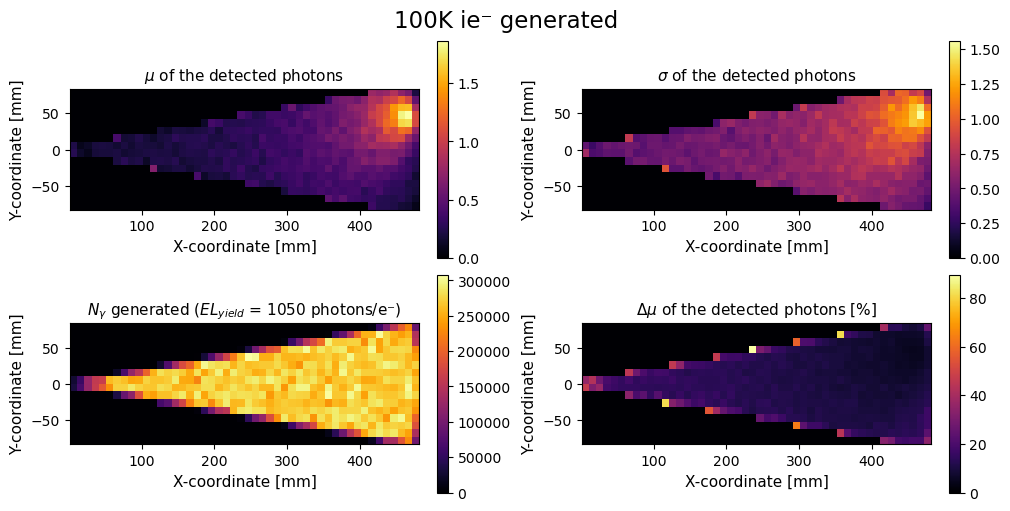

In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,5), constrained_layout=True)

mean_map = ax[0][0].pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
fig.colorbar(mean_map, ax = ax[0][0])
ax[0][0].set_title(r'$\mu$ of the detected photons', fontsize = font_size);

std_map = ax[0][1].pcolormesh(xedges, yedges, std_per_bin.T, cmap='inferno');
fig.colorbar(std_map, ax = ax[0][1])
ax[0][1].set_title(r'$\sigma$ of the detected photons', fontsize = font_size);

entries_map = ax[1][0].pcolormesh(xedges, yedges, entries_per_bin.T*yield_, cmap='inferno');
fig.colorbar(entries_map, ax = ax[1][0])
ax[1][0].set_title(r'$N_{\gamma}$ generated ($EL_{yield}$ = %s photons/e⁻)'%(yield_), fontsize = font_size);

err_map = ax[1][1].pcolormesh(xedges, yedges, mean_per_bin_err.T, cmap='inferno');
fig.colorbar(err_map, ax = ax[1][1])
ax[1][1].set_title(r'$\Delta\mu$ of the detected photons [%]', fontsize = font_size);

for row in ax:
    for axis in row:
        axis.set_xlim(xedges.min() - offset, xedges.max() + offset)
        axis.set_ylim([yedges.min() - offset, yedges.max() + offset])
        axis.set_xlabel('X-coordinate [mm]', fontsize = font_size)
        axis.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
        axis.set_aspect("equal") 
        

fig.suptitle(f'{int(n_events*1e-3)}K ie⁻ generated', fontsize = 1.5*font_size);

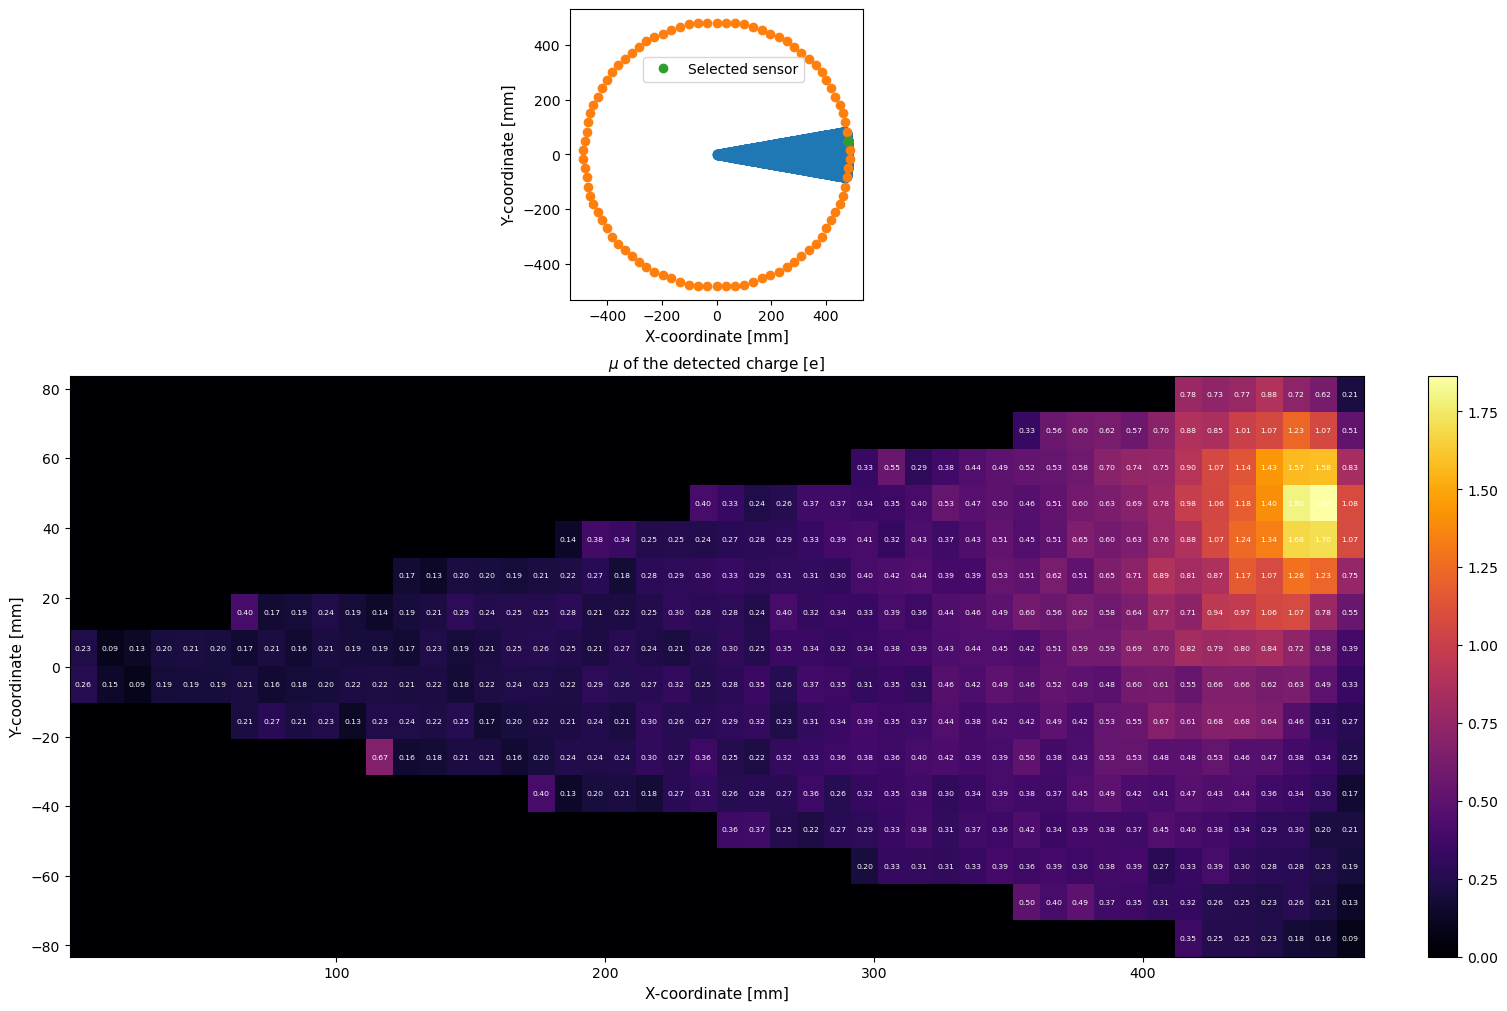

In [36]:
# gs_kw = {'height_ratios': [1], 'width_ratios': [1, 3]}
gs_kw = {'height_ratios': [1, 2], 'width_ratios': [1]}

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15,10), gridspec_kw=gs_kw, constrained_layout=True)

ax[0].plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
ax[0].plot(fib_sens.x, fib_sens.y, 'o')

this_sensor = fib_sens.loc[(fib_sens.sensor_id == selected_sens)]
ax[0].plot(this_sensor.x, this_sensor.y, 'o', label = "Selected sensor")

ax[0].legend(loc = (.25, .75))
ax[0].set_aspect("equal") 

mean_map = ax[1].pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
fig.colorbar(mean_map, ax = ax[1])
ax[1].set_title(r'$\mu$ of the detected charge [e]', fontsize = font_size);

ax[1].set_xlim(xedges.min() - offset, xedges.max() + offset)
ax[1].set_ylim([yedges.min() - offset, yedges.max() + offset])

for axx in ax:
    axx.set_xlabel('X-coordinate [mm]', fontsize = font_size)
    axx.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
#     axx.set_aspect("equal") 

# Annotate each cell with its numeric value
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = mean_per_bin[i, j]
        if value > 0:
            ax[1].annotate(f'{value:.2f}', ((xedges[i] + xedges[i + 1]) / 2, (yedges[j] + yedges[j + 1]) / 2),
                        color='white', ha='center', va='center', fontsize = .5*font_size)

In [39]:
import pandas as pd
import h5py

n_sens = len(sens_fibers.sensor_id)

s2_dict = {}

# for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)[:2]):
for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)):
    

    print(f'{ii:.0f}/{len(sens_fibers)}')

    sens_response = dst.loc[dst.sensor_id == selected_sens] # response of the selected sensor

    # keep track of the events with no counts
    no_counts_events = set(range(n_events)) - set(sens_response.event_id.unique()) 
    # print(f'Events {no_counts_events} did not have any counts')

    # Create a DataFrame with all event IDs
    all_event_ids = pd.DataFrame({'event_id': range(n_events)})

    # Merge the two DataFrames to align charge values
    sens_response = all_event_ids.merge(sens_response, on='event_id', how='left').fillna(0)


    event_charge = sens_response.groupby("event_id").charge.sum() # total charge detected on each event

# ****************************************************************************************

    # Create a 2D histogram
    hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                          bins=bins, 
                                          weights = event_charge,
                                          density=False);

    hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                                 bins=bins, 
                                                 density=False);

    # Calculate the mean values in each bin (normalized histogram)
    hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);

# ****************************************************************************************
    # Initialize lists to store statistics for each bin
    mean_per_bin = np.zeros((x_nbins, y_nbins))

    # Iterate over each bin
    for i in range(x_nbins):
        for j in range(y_nbins):
            # Indices of data points in the current bin
            mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                    (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))

            # Extract values and weights in the current bin
            values_in_bin = event_charge[mask]

            # Calculate weighted mean and standard deviation
            mean_value = np.mean(values_in_bin)

            # Append to lists
            mean_per_bin[i][j] = mean_value

    mean_per_bin = np.nan_to_num(mean_per_bin)
# ****************************************************************************************
    table_id = f'sens_{selected_sens}'
    table_data = pd.DataFrame(columns=[])
    
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            bin_x0 = xedges[i]
            bin_xf = xedges[i+1]
            bin_y0 = yedges[j]
            bin_yf = yedges[j+1]
            s2 = mean_per_bin[i, j]
            
            new_row = {'bin_x0':bin_x0, 'bin_xf':bin_xf,
                       'bin_y0':bin_y0, 'bin_yf':bin_yf,
                       's2':s2
                      }
            
            table_data = table_data.append(new_row, ignore_index=True)
#             print(table_data)

    s2_dict[table_id] = table_data
    
    
# Save the 3D dictionary using HDF5 format
with h5py.File('s2_table.h5', 'w') as file:
    for table_id, table_data in s2_dict.items():
        file.create_dataset(table_id, data=table_data.values)
        
# ****************************************************************************************


0/90


/tmp/ipykernel_12235/3394290668.py:42: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


1/90
2/90
3/90
4/90
5/90
6/90
7/90
8/90
9/90
10/90
11/90
12/90
13/90
14/90
15/90
16/90
17/90
18/90
19/90
20/90
21/90
22/90
23/90
24/90
25/90
26/90
27/90
28/90
29/90
30/90
31/90
32/90
33/90
34/90
35/90
36/90
37/90
38/90
39/90
40/90
41/90
42/90
43/90
44/90
45/90
46/90
47/90
48/90
49/90
50/90
51/90
52/90
53/90
54/90
55/90
56/90
57/90
58/90
59/90
60/90
61/90
62/90
63/90
64/90
65/90
66/90
67/90
68/90
69/90
70/90
71/90
72/90
73/90
74/90
75/90
76/90
77/90
78/90
79/90
80/90
81/90
82/90
83/90
84/90
85/90
86/90
87/90
88/90
89/90


In [ ]:

path = '/home/investigator/mariandbt/python/notebooks'

filename = os.path.join(path, "s2_dict.h5")

with tb.open_file(filename) as file:
    print(file)

In [ ]:
s2_dict['Table_200']

In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages

# # Specify the PDF file name
# pdf_filename = 'output5.pdf'

# # Create a PdfPages object to save the figures in the PDF
# with PdfPages(pdf_filename) as pdf:
    
#     for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)[50:90]):
# #     for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)):
        
#         print(f'{ii:.0f}/{len(sens_fibers)}')
    
#         sens_response = dst.loc[dst.sensor_id == selected_sens] # response of the selected sensor

#         # keep track of the events with no counts
#         no_counts_events = set(range(n_events)) - set(sens_response.event_id.unique()) 
#         # print(f'Events {no_counts_events} did not have any counts')

#         # Create a DataFrame with all event IDs
#         all_event_ids = pd.DataFrame({'event_id': range(n_events)})

#         # Merge the two DataFrames to align charge values
#         sens_response = all_event_ids.merge(sens_response, on='event_id', how='left').fillna(0)


#         event_charge = sens_response.groupby("event_id").charge.sum() # total charge detected on each event

# # ****************************************************************************************

#         # Create a 2D histogram
#         hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
#                                               bins=bins, 
#                                               weights = event_charge,
#                                               density=False);

#         hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
#                                                      bins=bins, 
#                                                      density=False);

#         # Calculate the mean values in each bin (normalized histogram)
#         hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);
        
# # ****************************************************************************************
#         # Initialize lists to store statistics for each bin
#         mean_per_bin = np.zeros((x_nbins, y_nbins))

#         # Iterate over each bin
#         for i in range(x_nbins):
#             for j in range(y_nbins):
#                 # Indices of data points in the current bin
#                 mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
#                         (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))

#                 # Extract values and weights in the current bin
#                 values_in_bin = event_charge[mask]

#                 # Calculate weighted mean and standard deviation
#                 mean_value = np.mean(values_in_bin)

#                 # Append to lists
#                 mean_per_bin[i][j] = mean_value

#         mean_per_bin = np.nan_to_num(mean_per_bin)
# # ****************************************************************************************

#         # gs_kw = {'height_ratios': [1], 'width_ratios': [1, 3]}
#         gs_kw = {'height_ratios': [1, 2], 'width_ratios': [1]}

#         fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15,10), gridspec_kw=gs_kw, constrained_layout=True)

#         ax[0].plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

#         fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
#         ax[0].plot(fib_sens.x, fib_sens.y, 'o')

#         this_sensor = fib_sens.loc[(fib_sens.sensor_id == selected_sens)]
#         ax[0].plot(this_sensor.x, this_sensor.y, 'o', label = "Selected sensor")

#         ax[0].legend(loc = (.25, .75))
#         ax[0].set_aspect("equal") 

#         mean_map = ax[1].pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
#         fig.colorbar(mean_map, ax = ax[1])
#         ax[1].set_title(r'$\mu$ of the detected charge [e]', fontsize = font_size);

#         ax[1].set_xlim(xedges.min() - offset, xedges.max() + offset)
#         ax[1].set_ylim([yedges.min() - offset, yedges.max() + offset])

#         for axx in ax:
#             axx.set_xlabel('X-coordinate [mm]', fontsize = font_size)
#             axx.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
#         #     axx.set_aspect("equal") 

#         # Annotate each cell with its numeric value
#         for i in range(len(xedges) - 1):
#             for j in range(len(yedges) - 1):
#                 value = mean_per_bin[i, j]
#                 if value > 0:
#                     ax[1].annotate(f'{value:.2f}', ((xedges[i] + xedges[i + 1]) / 2, (yedges[j] + yedges[j + 1]) / 2),
#                                 color='white', ha='center', va='center', fontsize = .5*font_size)

#         pdf.savefig()
#         plt.close()